# 1. 환경설정

- 파이토치

- 한국어를 영어로 번역하는 Seq2Seq(기본 모델, Attention 적용 모델)을 구현

- JSON 파일(train_set.json, valid_set.json) 형식

- 데이터셋 각 항목은 한국어 문장("ko")과 영어 번역문("mt")으로 구성

- 적절한 토크나이저를 선택하여 한국어, 영어 문장을 토큰화

- 필요한 경우 SOS, EOS, PAD, UNK 등의 특수 토큰을 정의

- 한국어와 영어 각각의 어휘 사전 구성

- Seq2Seq 모델: GRU 기반의 Encoder-Decoder 모델을 구현하고, Teacher Forcing 기법을 적용해 학습

- Attention 모델: Attention(Bahdanau 혹은 Luong)을 적용한 디코더를 구현

- 무작위 문장 쌍에 대해 모델의 번역 결과를 출력

- 다양한 평가 지표(예: BLEU 점수) 도입

In [ ]:
""" 디렉토리 설정 """
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive; drive.mount('/content/drive')
    import drive.MyDrive.develop.config_my_path as cc
    cc.dir('projects/side/250625-250702_machine-translator/machine-translator')


""" 라이브러리 설정 """
# 시스템 & 유틸
import os
import json
import random
import numpy as np
from tqdm import tqdm
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 전처리
!pip install kiwipiepy
!pip install konlpy
from kiwipiepy import Kiwi
from konlpy.tag import Mecab
import spacy
from collections import Counter

# BLEU
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 디바이스
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive
/content/drive/MyDrive/develop/projects/side/250625-250702_machine-translator/machine-translator
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 58.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 92.7 MB/s eta 0:00:00
  Created wheel for kiwipiepy_model: filename=kiwipiepy_model-0.21.0-py3-none-any.whl size=35593192 sha256=21d9d33540465c706405fe59e0c1129bd2eb48e0205d7f7b7ce4861829bb145e
  Stored in directory: /root/.cache/pip/wheels/b0/16/3d/95053ab5298f0f0f22ffea6de0200b6f24bffb73cab4c1a828
Successfully built kiwipiepy_model
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 26.9 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 2. EDA

Train datas: 1200000
Valid datas: 150000
----------------
KO: 원하시는 색상을 회신해 주시면 바로 제작 들어가겠습니다.
MT: If you reply to the color you want, we will start making it right away.
----------------
KO Avg Length: 27
EN Avg Length: 54
KO Max Length: 297
EN Max Length: 377
----------------
KO Avg Length: 27
EN Avg Length: 54
KO Max Length: 282
EN Max Length: 295
----------------


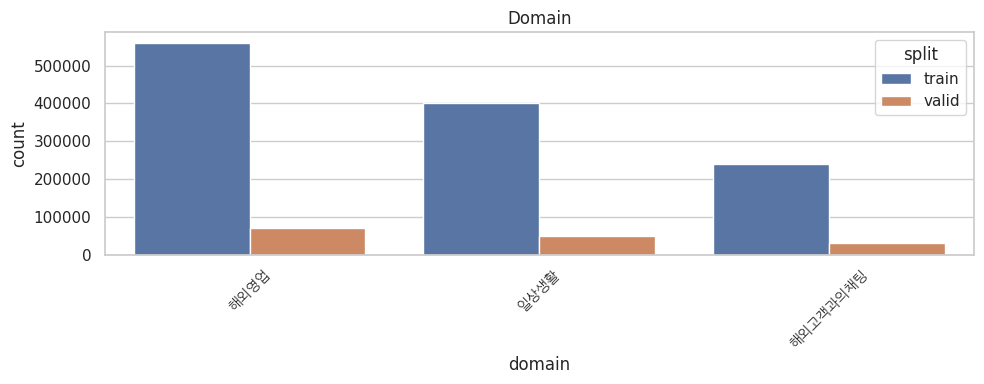

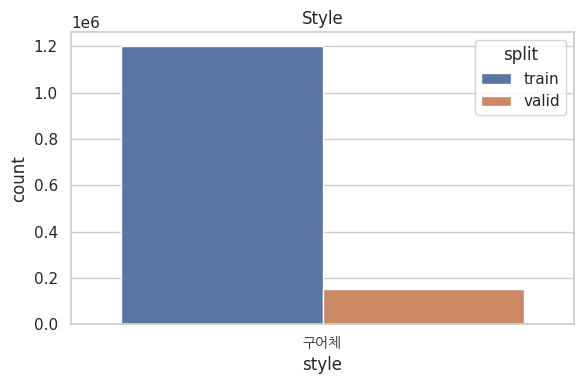

In [ ]:
# JSON 기본 정보 확인
def load_json_data(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data['data']

train_path = 'train_set.json'
valid_path = 'valid_set.json'

train_data = load_json_data(train_path)
valid_data = load_json_data(valid_path)

print(f"Train datas: {len(train_data)}")
print(f"Valid datas: {len(valid_data)}")
print("----------------")
print("KO:", train_data[0]['ko'])
print("MT:", train_data[0]['mt'])
print("----------------")
train_data[0]


# 문장 길이 측정
def get_sentence_lengths(data):
    ko_lens = [len(item['ko']) for item in data]
    en_lens = [len(item['mt']) for item in data]
    return ko_lens, en_lens

ko_lengths_train, en_lengths = get_sentence_lengths(train_data)
print(f"KO Avg Length: {np.mean(ko_lengths_train):.0f}")
print(f"EN Avg Length: {np.mean(en_lengths):.0f}")
print(f"KO Max Length: {max(ko_lengths_train)}")
print(f"EN Max Length: {max(en_lengths)}")
print("----------------")

ko_lengths_valid, en_lengths = get_sentence_lengths(valid_data)
print(f"KO Avg Length: {np.mean(ko_lengths_valid):.0f}")
print(f"EN Avg Length: {np.mean(en_lengths):.0f}")
print(f"KO Max Length: {max(ko_lengths_valid)}")
print(f"EN Max Length: {max(en_lengths)}")
print("----------------")

# 폰트 등록
font_path = "NanumGothic.ttf"
fontprop = fm.FontProperties(fname=font_path)
font_name = fontprop.get_name()

# JSON 데이터 로딩
with open('train_set.json', encoding='utf-8') as f:
    train_data = json.load(f)['data']
with open('valid_set.json', encoding='utf-8') as f:
    valid_data = json.load(f)['data']

train_df = pd.DataFrame(train_data)
train_df['split'] = 'train'
valid_df = pd.DataFrame(valid_data)
valid_df['split'] = 'valid'

df = pd.concat([train_df, valid_df], ignore_index=True)

sns.set(style="whitegrid")

# domain 분포
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='domain', hue='split', order=df['domain'].value_counts().index)
plt.title('Domain')
plt.xticks(fontproperties=fontprop)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# style 분포
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='style', hue='split', order=df['style'].value_counts().index)
plt.title('Style')
plt.xticks(fontproperties=fontprop)
plt.tight_layout()
plt.show()

# 3. 전처리

In [10]:
import json
import os
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from kiwipiepy import Kiwi
import spacy
from tqdm import tqdm

# =================================================================================
# 1. 기본 구성 요소 (클래스 및 함수)
# =================================================================================

# 특수 토큰 정의
SPECIAL_TOKENS = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}

class Tokenizer:
    """한국어(Kiwi)와 영어(Spacy) 토크나이저를 포함하는 클래스"""
    def __init__(self):
        self.kiwi = Kiwi()
        self.en = spacy.load("en_core_web_sm")

    def tokenize_ko(self, text):
        return [t.form for t in self.kiwi.tokenize(text)]

    def tokenize_en(self, text):
        return [t.text.lower() for t in self.en(text)]

def encode(tokens, vocab, add_sos_eos=True):
    """토큰 리스트를 인덱스 시퀀스로 변환하는 함수"""
    ids = [vocab.get(t, SPECIAL_TOKENS["<unk>"]) for t in tokens]
    if add_sos_eos:
        return [SPECIAL_TOKENS["<sos>"]] + ids + [SPECIAL_TOKENS["<eos>"]]
    return ids

class IndexedDataset(Dataset):
    """인덱싱된 데이터 쌍을 위한 PyTorch Dataset 클래스"""
    def __init__(self, indexed_data):
        self.data = indexed_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (torch.tensor(self.data[idx]['ko']), torch.tensor(self.data[idx]['mt']))

def collate_fn(batch):
    """배치 데이터를 패딩하여 동일한 길이로 맞추는 함수"""
    ko_batch, en_batch = zip(*batch)
    ko_pad = torch.nn.utils.rnn.pad_sequence(ko_batch, batch_first=True, padding_value=SPECIAL_TOKENS["<pad>"])
    en_pad = torch.nn.utils.rnn.pad_sequence(en_batch, batch_first=True, padding_value=SPECIAL_TOKENS["<pad>"])
    return ko_pad, en_pad

def build_vocab_from_tokens(tokenized_sentences, min_freq=2):
    """토큰화된 문장 리스트로부터 단어 사전을 생성하는 함수"""
    counter = Counter(token for sentence in tokenized_sentences for token in sentence)
    vocab = {token: idx for idx, (token, freq) in enumerate(counter.items(), start=4) if freq >= min_freq}
    return {**SPECIAL_TOKENS, **vocab}

def prepare_dataset(file_path, tokenizer, ko_vocab=None, en_vocab=None):
    """
    하나의 데이터셋 파일을 읽고 전처리하는 핵심 함수.
    - ko_vocab, en_vocab이 없으면(None) 새로 만들고, (훈련용)
    - 있으면 기존 것을 그대로 사용한다. (검증용)
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)['data']

    ko_sents = [d['ko'] for d in data]
    en_sents = [d['mt'] for d in data]
    ko_tokenized = [tokenizer.tokenize_ko(sent) for sent in tqdm(ko_sents, desc=f"Tokenizing KO ({os.path.basename(file_path)})")]
    en_tokenized = [tokenizer.tokenize_en(sent) for sent in tqdm(en_sents, desc=f"Tokenizing EN ({os.path.basename(file_path)})")]

    if ko_vocab is None or en_vocab is None:
        print("Building new vocabularies from this data...")
        ko_vocab = build_vocab_from_tokens(ko_tokenized)
        en_vocab = build_vocab_from_tokens(en_tokenized)
        we_built_vocab = True
    else:
        print("Using existing vocabularies...")
        we_built_vocab = False

    indexed_data = []
    for ko_tokens, en_tokens in tqdm(zip(ko_tokenized, en_tokenized), total=len(data), desc=f"Encoding ({os.path.basename(file_path)})"):
        ko_ids = encode(ko_tokens, ko_vocab)
        en_ids = encode(en_tokens, en_vocab)
        indexed_data.append({'ko': ko_ids, 'mt': en_ids})

    if we_built_vocab:
        return indexed_data, ko_vocab, en_vocab
    else:
        return indexed_data

# =================================================================================
# 2. 메인 실행 로직
# =================================================================================

# 사용할 파일 경로 정의
train_json_path = 'train_set.json'
valid_json_path = 'valid_set.json'
train_cache_path = 'tokenized_train.pt'
valid_cache_path = 'tokenized_valid.pt'
BATCH_SIZE = 64

# 토크나이저 생성 (한 번만)
tokenizer = Tokenizer()

# --- 훈련 데이터(Train Data) 처리 ---
print(f"--- [1/2] Processing Train Data ---")
if os.path.exists(train_cache_path):
    print(f"✅ Train cache found! Loading from '{train_cache_path}'...")
    train_data_indexed, ko_vocab, en_vocab = torch.load(train_cache_path)
else:
    print(f"❌ Train cache not found. Processing '{train_json_path}' from scratch...")
    train_data_indexed, ko_vocab, en_vocab = prepare_dataset(train_json_path, tokenizer)
    print(f"💾 Saving train data to cache: '{train_cache_path}'")
    torch.save((train_data_indexed, ko_vocab, en_vocab), train_cache_path)

# --- 검증 데이터(Validation Data) 처리 ---
print(f"\n--- [2/2] Processing Validation Data ---")
if os.path.exists(valid_cache_path):
    print(f"✅ Valid cache found! Loading from '{valid_cache_path}'...")
    valid_data_indexed = torch.load(valid_cache_path)
else:
    print(f"❌ Valid cache not found. Processing '{valid_json_path}' from scratch...")
    # 중요: 훈련 데이터로 만든 단어장을 그대로 전달!
    valid_data_indexed = prepare_dataset(valid_json_path, tokenizer, ko_vocab=ko_vocab, en_vocab=en_vocab)
    print(f"💾 Saving valid data to cache: '{valid_cache_path}'")
    torch.save(valid_data_indexed, valid_cache_path)

# --- 최종 데이터로더 생성 ---
train_dataset = IndexedDataset(train_data_indexed)
valid_dataset = IndexedDataset(valid_data_indexed)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# --- 로더 확인 ---
print("\n--- All loaders are ready! ---")
print(f"Train batches: {len(train_loader)}, Valid batches: {len(valid_loader)}")
print("\n--- Sample from Train Loader ---")
for ko, en in train_loader:
    print(f"KO batch shape: {ko.shape}, EN batch shape: {en.shape}")
    break

print("\n--- Sample from Valid Loader ---")
for ko, en in valid_loader:
    print(f"KO batch shape: {ko.shape}, EN batch shape: {en.shape}")
    break

--- [1/2] Processing Train Data ---
✅ Train cache found! Loading from 'tokenized_train.pt'...

--- [2/2] Processing Validation Data ---
❌ Valid cache not found. Processing 'valid_set.json' from scratch...


Tokenizing EN (valid_set.json): 100%|██████████| 150000/150000 [19:45<00:00, 126.58it/s]


Using existing vocabularies...


Encoding (valid_set.json): 100%|██████████| 150000/150000 [00:01<00:00, 100533.82it/s]


💾 Saving valid data to cache: 'tokenized_valid.pt'

--- All loaders are ready! ---
Train batches: 18750, Valid batches: 2344

--- Sample from Train Loader ---
KO batch shape: torch.Size([64, 43]), EN batch shape: torch.Size([64, 33])

--- Sample from Valid Loader ---
KO batch shape: torch.Size([64, 29]), EN batch shape: torch.Size([64, 26])


# 4. 모델 구현

## GRU 기반 Seq2Seq

In [5]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        return hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hid_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, context):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        emb_con = torch.cat((embedded, context.unsqueeze(0)), dim=2)
        output, hidden = self.rnn(emb_con, hidden)
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        context = self.encoder(src)
        hidden = context
        input = trg[0,:]

        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, context[-1])
            outputs[t] = output
            teacher_force = torch.rand(1) < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

## GRU 기반 Seq2Seq with Bahdanau Attention

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttnEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        return outputs, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return F.softmax(attention, dim=1)

class AttnDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        a = self.attention(hidden, encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        return prediction, hidden.squeeze(0)

class AttnSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0,:]

        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = torch.rand(1) < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

## 모델 인스턴스 생성

In [12]:
# =================================================================================
# 5. 모델 인스턴스 생성
# =================================================================================

# 하이퍼파라미터 정의
# INPUT_DIM과 OUTPUT_DIM은 전처리 과정에서 만든 단어장의 크기를 사용!
INPUT_DIM = len(ko_vocab)
OUTPUT_DIM = len(en_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512       # 기본 모델용
ENC_HID_DIM = 512   # 어텐션 모델용
DEC_HID_DIM = 512   # 어텐션 모델용
N_LAYERS = 1        # 기본 모델은 1층으로 어텐션 모델과 통일
DROPOUT = 0.5
LEARNING_RATE = 0.0005
N_EPOCHS = 10
CLIP = 1.0 # Gradient Clipping
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"\n--- Training Setup ---")
print(f"Device: {DEVICE}")
print(f"Input Vocab Size (KO): {INPUT_DIM}")
print(f"Output Vocab Size (EN): {OUTPUT_DIM}")

# --- 모델 2개 생성 ---
# 1. 기본 Seq2Seq 모델
basic_enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
basic_dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DROPOUT)
model_basic = Seq2Seq(basic_enc, basic_dec, DEVICE).to(DEVICE)

# 2. 어텐션 Seq2Seq 모델
attn = BahdanauAttention(ENC_HID_DIM, DEC_HID_DIM)
attn_enc = AttnEncoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DROPOUT)
attn_dec = AttnDecoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DROPOUT, attn)
model_attn = AttnSeq2Seq(attn_enc, attn_dec, DEVICE).to(DEVICE)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The Basic model has {count_parameters(model_basic):,} trainable parameters')
print(f'The Attention model has {count_parameters(model_attn):,} trainable parameters')



# =================================================================================
# 6. Optimizer 및 Loss Function 정의
# =================================================================================

PAD_IDX = SPECIAL_TOKENS['<pad>']

opt_basic = optim.Adam(model_basic.parameters(), lr=LEARNING_RATE)
criterion_basic = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

opt_attn = optim.Adam(model_attn.parameters(), lr=LEARNING_RATE)
criterion_attn = nn.CrossEntropyLoss(ignore_index=PAD_IDX)



--- Training Setup ---
Device: cpu
Input Vocab Size (KO): 42419
Output Vocab Size (EN): 36593


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


The Basic model has 42,151,153 trainable parameters
The Attention model has 92,271,601 trainable parameters


# 5. 모델 훈련

In [13]:
def train_and_evaluate(model, train_loader, valid_loader, optimizer, criterion, device,
                       num_epochs=10, clip=1.0, teacher_forcing_ratio=0.5):

    # 모델 이름 가져오기 (파일 저장용)
    model_name = model.__class__.__name__
    best_valid_loss = float('inf')

    print(f"\n===== Starting Training for: {model_name} =====")

    for epoch in range(1, num_epochs + 1):
        start_time = time.time()

        # --- Train ---
        model.train()
        total_train_loss = 0
        for src, trg in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
            # src, trg: [배치 크기, 문장 길이]
            src, trg = src.to(device), trg.to(device)

            optimizer.zero_grad()

            # 모델 입력 전 .T 로 전치 -> [문장 길이, 배치 크기]
            output = model(src.T, trg.T, teacher_forcing_ratio)

            # output: [문장 길이, 배치 크기, 단어 수]
            output_dim = output.shape[-1]

            # loss 계산을 위해 SOS 토큰 제외하고 2D로 reshape
            output_reshaped = output[1:].view(-1, output_dim)
            trg_reshaped = trg.T[1:].view(-1) # trg도 전치 후 reshape

            loss = criterion(output_reshaped, trg_reshaped)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            total_train_loss += loss.item()

        # --- Evaluate ---
        model.eval()
        total_valid_loss = 0
        with torch.no_grad():
            for src, trg in tqdm(valid_loader, desc=f"Epoch {epoch} Evaluating"):
                src, trg = src.to(device), trg.to(device)
                output = model(src.T, trg.T, 0.0) # no teacher forcing

                output_dim = output.shape[-1]
                output_reshaped = output[1:].view(-1, output_dim)
                trg_reshaped = trg.T[1:].view(-1)

                loss = criterion(output_reshaped, trg_reshaped)
                total_valid_loss += loss.item()

        # --- 결과 출력 ---
        avg_train_loss = total_train_loss / len(train_loader)
        avg_valid_loss = total_valid_loss / len(valid_loader)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f"\nEpoch: {epoch:02}/{num_epochs} | Time: {epoch_mins}m {epoch_secs}s")
        print(f"\tTrain Loss: {avg_train_loss:.3f} | Train PPL: {math.exp(avg_train_loss):7.3f}")
        print(f"\t Val. Loss: {avg_valid_loss:.3f} |  Val. PPL: {math.exp(avg_valid_loss):7.3f}")

        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            torch.save(model.state_dict(), f'best-model-{model_name}.pth')
            print("✅ Best model saved.")

# --- 함수 호출 예시 ---
# train_and_evaluate(model_attn, train_loader, valid_loader, opt_attn, criterion_attn, DEVICE)
# train_and_evaluate(model_basic, train_loader, valid_loader, opt_basic, criterion_basic, DEVICE)

# 7. 모델 평가

In [ ]:
# =================================================================================
# 9. 훈련된 모델 최종 성능 평가 (BLEU 점수)
# =================================================================================

# BLEU 계산에 필요한 함수들 (이전 답변에서 제공한 코드)
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len=50):
    model.eval()
    if isinstance(sentence, str):
        tokens = tokenizer.tokenize_ko(sentence)
    else:
        tokens = [token for token in sentence]

    tokens = ['<sos>'] + tokens + ['<eos>']
    src_indexes = [src_vocab.get(token, src_vocab['<unk>']) for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    trg_indexes = [trg_vocab['<sos>']]
    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden = model.decoder(trg_tensor, hidden, encoder_outputs)
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == trg_vocab['<eos>']:
            break

    trg_tokens = [list(trg_vocab.keys())[list(trg_vocab.values()).index(i)] for i in trg_indexes]
    return trg_tokens[1:-1] # <sos>와 <eos> 제외

def calculate_bleu(raw_data, model, device):
    trgs = []
    pred_trgs = []

    for datum in tqdm(raw_data, desc=f"Calculating BLEU for {model.__class__.__name__}"):
        src = datum['ko']
        trg = tokenizer.tokenize_en(datum['mt']) # 정답도 동일하게 토큰화

        pred_trg = translate_sentence(src, ko_vocab, en_vocab, model, device)

        pred_trgs.append(pred_trg)
        trgs.append([trg])

    smoothie = SmoothingFunction().method4
    return sentence_bleu(trgs, pred_trgs, smoothing_function=smoothie)

# --- 메인 평가 로직 ---

# 1. 평가에 사용할 원본 검증 데이터 로드
print("\n--- Starting Final Evaluation (BLEU Score) ---")
with open('valid_set.json', 'r', encoding='utf-8') as f:
    valid_raw_data = json.load(f)['data']

# 2. 저장된 모델들을 불러와서 BLEU 점수 계산
models_to_evaluate = [
    (model_basic, 'best-model-Seq2Seq.pth'),
    (model_attn, 'best-model-AttnSeq2Seq.pth')
]

for model, model_path in models_to_evaluate:
    try:
        model.load_state_dict(torch.load(model_path))
        bleu_score = calculate_bleu(valid_raw_data, model, device)
        print(f"✅ BLEU score for {model.__class__.__name__}: {bleu_score*100:.2f}")
    except FileNotFoundError:
        print(f"❌ Could not find saved model at '{model_path}'. Skipping.")
    except Exception as e:
        print(f"An error occurred while evaluating {model_path}: {e}")